In [146]:
import torch
from utils import BoidImagesDataset, valid_transform

from autoencoders import VanillaVAE, LightningAutoEncoder
from flows import RealNVP, LightningINN

from scipy.stats import norm
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [147]:
parameter_names = [
    'N_boids',
    'N_obstacles',
    'L_separation',
    'L_coherence',
    'L_aligment',
    'L_avoidance',
    'visual_range',
    'avoid_range'
]

In [148]:
autoencoder = VanillaVAE(3, 500)
model = LightningAutoEncoder.load_from_checkpoint("autoencoder.ckpt", autoencoder=autoencoder)

In [149]:
inn = RealNVP(8, 200, 5, 500)
model = LightningINN.load_from_checkpoint("realnvp.ckpt", inn=inn, encoder=autoencoder.encode)

In [150]:
validation_dataset = BoidImagesDataset('boid_validation', transform=valid_transform)
validation_dataset = BoidImagesDataset('boid_data', transform=valid_transform)

In [152]:
len(validation_dataset)

20000

In [151]:
# generate P_i values

P_i_values = np.zeros((len(validation_dataset), 8))
for i, (params, img) in enumerate(tqdm(validation_dataset)):

    # encode
    params = torch.from_numpy(params).reshape(1, -1).to(device)
    img = img.to(device)
    encoded, _ = autoencoder.encode(img.reshape(1, 3, 64, 64))

    # pass in INN -> get norm distr.
    code = inn.forward(params, encoded)

    # apply CDF -> get probs
    P_i_values[i] = norm.cdf(code.detach().cpu())


100%|██████████| 20000/20000 [01:17<00:00, 257.58it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'boid_data/images/img20000.png'

In [153]:
grid_resolution = 200
# create grid of alpha values
alphas = np.linspace(0, 1, grid_resolution, endpoint=True)

# calc r_i_alpha values (mean of P_i <= alpha)
r_i_alphas = np.zeros((8, grid_resolution))

for i, column in enumerate(tqdm(P_i_values.T)):
    r_i_alphas[i] = np.mean(column[:, None] <= alphas, axis=0)


100%|██████████| 8/8 [00:00<00:00, 249.78it/s]


In [154]:
# think about what to use as input here: probably use one instance (paramaters, img) as input and vary one paramter to analyze it and its local behavior

T_i = np.zeros(8)

for i, row in enumerate(tqdm(r_i_alphas)):
    print(np.mean(np.square(row - alphas)))

100%|██████████| 8/8 [00:00<?, ?it/s]

0.005691025567839196
0.006487157642085429
0.004100210698932162
0.01045686811187186
0.015250274023994979
0.013708261586494973
0.01497464970232412
0.047621881535741206


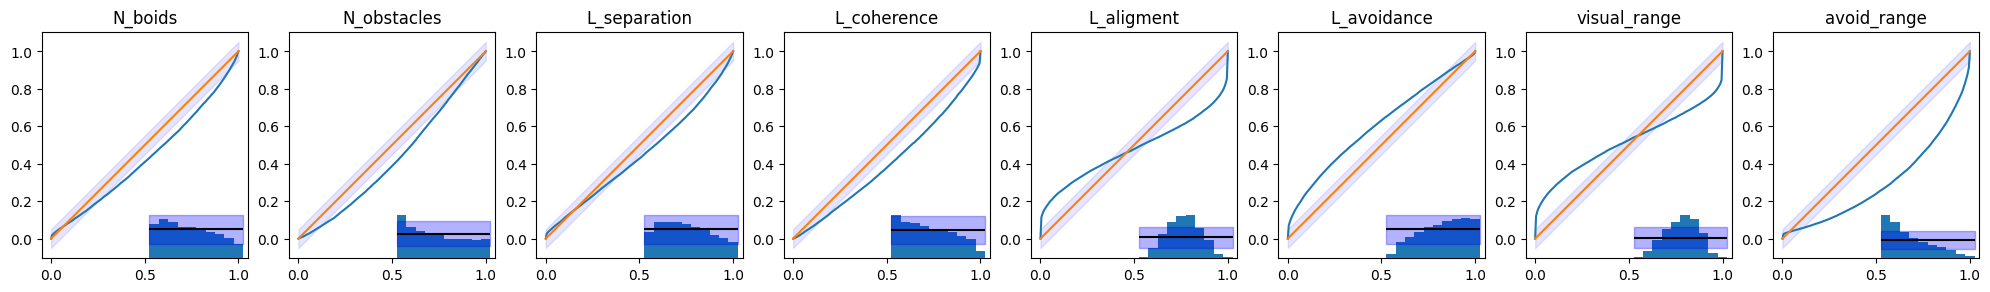

In [155]:
# plot r_i_alphas
fig, ax = plt.subplots(1, 8, figsize=(25, 5))
for i, values in enumerate(r_i_alphas):
    ax[i].plot(alphas, values)
    ax[i].plot(alphas, alphas)
    ax[i].set_title(parameter_names[i])
    ax[i].set_aspect(1)
    ax[i].fill_between(alphas, (alphas-0.05), (alphas+0.05), color='b', alpha=.1)

    inset_axes = ax[i].inset_axes(bounds=[0.5,0,0.5,0.2])
    inset_axes.hist(r_i_alphas[i], bins=10)
    inset_axes.axis(False)
    inset_axes.hlines(len(values) / 10, 0, 1, colors='black')
    inset_axes.fill_between(alphas, (len(values) / 10 - 0.05*len(alphas)), (len(values) / 10 + 0.05*len(alphas)), color='b', alpha=.3)

plt.title(parameter_names[i])
plt.show()

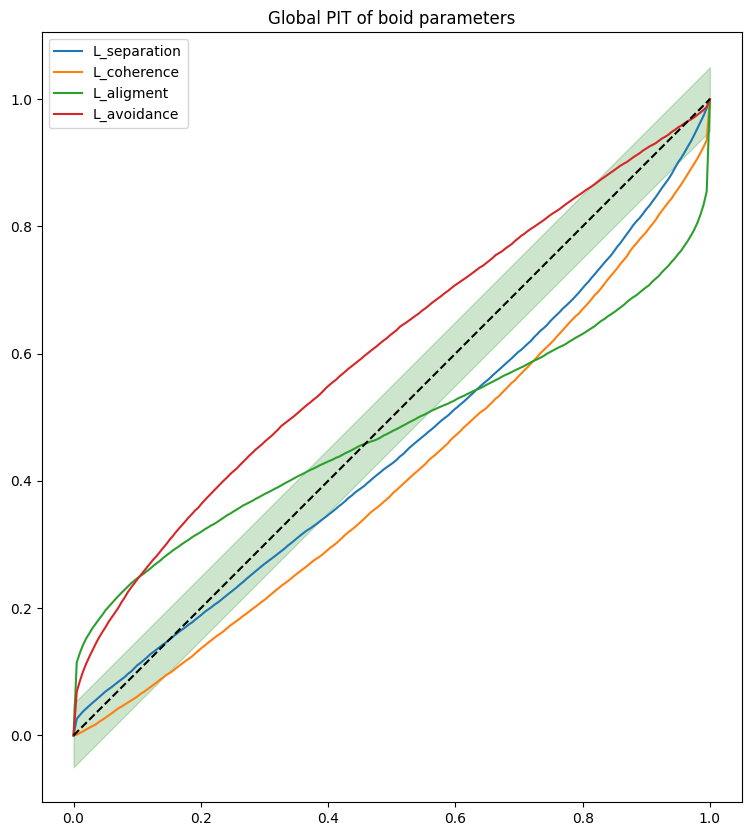

In [156]:
# plot r_i_alphas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, values in enumerate(r_i_alphas):
    if i in [0, 1, 6, 7]:
        continue
    ax.plot(alphas, values, label=parameter_names[i])
    ax.set_title(parameter_names[i])
    ax.set_aspect(1)


ax.plot(alphas, alphas, color='black', linestyle='--')
ax.fill_between(alphas, (alphas-0.05), (alphas+0.05), color='g', alpha=.2)
plt.title('Global PIT of boid parameters')
plt.legend()
plt.show()